In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time
import cv2

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import random

from multiprocessing import Pool
import math
import pickle

In [2]:
# Generating training and testing set.
hisDir = '/oasis/projects/nsf/csd395/ruogu/boosting/training_L0/';
figsaveDir = '/oasis/projects/nsf/csd395/ruogu/boosting/figure/training_L0/';
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL'];
fileNames = os.listdir(hisDir);
fileNames = sorted(fileNames);
bg_histogram_files = [f for f in fileNames if 'surround' in f and '.npy' in f];
Nonbg_histogram_files = [f for f in fileNames if 'surround' not in f and '.npy' in f];
Background = [(np.load(hisDir + f), labels.index('BackG'), pickle.load(open(hisDir + f[:-4]+".p", "rb"))) for f in bg_histogram_files];
NonBg = [(np.load(hisDir + f), labels.index(f[:-4]), pickle.load(open(hisDir + f[:-4]+".p", "rb"))) for f in Nonbg_histogram_files];
X = [];
y = [];
f = [];
for data in NonBg:
    label = data[1];
    for i in range(0, data[0].shape[0]):
        X.append(data[0][i]);
        y.append(label);
        f.append(data[2][i]);

bg = [];
bg_y=[]
bg_f = []
for data in Background:
    label = data[1];
    for i in range(0, data[0].shape[0]):
        bg.append(data[0][i]);
        bg_y.append(label);
        bg_f.append(data[2][i]);
bg_samples = random.sample(zip(bg, bg_y, bg_f), 1000);
bg = [x[0] for x in bg_samples];
bg_y = [x[1] for x in bg_samples];
bg_f = [x[2] for x in bg_samples];

X = X + bg;
y = y + bg_y;
f = f + bg_f;

X = np.asarray(X);
y = np.asarray(y);

raw_data = zip(X, y, f);
random.shuffle(raw_data);

quota = 0.8;
n_training = int(len(raw_data)*quota);
n_testing = len(raw_data) - n_training;
training_X = np.asarray([x[0] for x in raw_data[:n_training]]);
training_y = np.asarray([x[1] for x in raw_data[:n_training]]);
training_f = [x[2] for x in raw_data[:n_training]];
testing_X = np.asarray([x[0] for x in raw_data[n_training:]]);
testing_y = np.asarray([x[1] for x in raw_data[n_training:]]);
testing_f = [x[2] for x in raw_data[n_training:]];

In [3]:
# Train in parallel.
def train_job(i):
    xi = training_X[i];
    his = 0.5 * np.sum(training_X + xi - np.abs(training_X - xi), axis=1); # Equals to min(xi, xj)
    return (i, his);

start = time();
pool = Pool(processes=16); # This is a compution-heavy work, so we can have more process, like 15.
result_train = pool.map(train_job, range(0, n_training));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);
result_train = sorted(result_train, key=lambda x: x[0]);
myTrainKernel = np.asarray([v[1] for v in result_train]);
myTrainKernel = myTrainKernel.reshape(n_training, n_training);

Kernel calculation takes 47.2224059105 sec.


In [4]:
print '%s' %(myTrainKernel.shape,);
print myTrainKernel.max();

(7951, 7951)
1.0


In [5]:
# Testing
def test_job(i):
    xi = training_X[i];
    his = 0.5 * np.sum(testing_X + xi - np.abs(testing_X - xi), axis=1); # Equals to min(xi, xj)
    return (i, his);

start = time();
pool = Pool(processes=16); # This is a compution-heavy work, so we can have more process, like 15.
result_test = pool.map(test_job, range(0, n_training));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);
result_test = sorted(result_test, key=lambda x: x[0]);
myTestKernel = np.asarray([v[1] for v in result_test]);
myTestKernel = myTestKernel.reshape(n_training, n_testing);

Kernel calculation takes 11.0943191051 sec.


In [7]:
print '%s' %(myTestKernel.shape,);
print myTestKernel.max();

(7951, 1988)
1.0


In [8]:
class BaseClassifier:
    def __init__(self, histogram, threshold, label, alpha, size, acc, index, 
                 unweighted_acc, label_distribution, neighbor_indices):
        self.h = histogram;
        self.t = threshold;
        self.l = label;
        self.alpha = alpha;
        self.size = size;
        self.acc = acc; # Weighted accuracy
        self.index = index;
        self.unweighted_acc = unweighted_acc;
        self.label_distribution = label_distribution;
        self.neighbor_indices = neighbor_indices;
class Adaboost:    
    def __init__(self, iteration, n_class, stride, init_ball_size, enter_t):
        self.clfs = [];
        self.t = iteration;
        self.n_class = n_class;
        self.stride = stride;
        self.init_ball_size = init_ball_size;
        self.enter_t = enter_t;

    # precomputed_score is the score matrix
    def fit(self, precomputed_scores, X, y):
        n_samples = precomputed_scores.shape[0];
        weights = np.zeros(n_samples);
        weights.fill(1.0 / n_samples);
        for t in range(0, self.t):
            # Choose example
            exemplar_index = np.random.choice(range(n_samples), p=weights.tolist());
            exemplar = X[exemplar_index];
            # Calculate similarity scores
            scores = precomputed_scores[exemplar_index];
            score_label_weight_index = zip(scores, y, weights, np.arange(n_samples));
            score_label_weight_index = sorted(score_label_weight_index, 
                                              key=lambda x: x[0], reverse=True);
            sorted_labels = [x[1] for x in score_label_weight_index];
            sorted_weights = [x[2] for x in score_label_weight_index];
            sorted_indices = [x[3] for x in score_label_weight_index];
            # Choose the plurality in the initial ball size
            count = np.bincount(sorted_labels[:self.init_ball_size], 
                                weights = sorted_weights[:self.init_ball_size],
                                minlength=10);
            label_of_interest = np.argmax(count);
            label_fraction = count[label_of_interest] / sum(sorted_weights[:self.init_ball_size]);
            if label_fraction < self.enter_t or label_of_interest == 0:
                # Discard this classifer
                continue;
            # Calculate threshold
            n_max = self.init_ball_size;
            n_label_of_interest = count[label_of_interest];
            for n in range(self.init_ball_size + self.stride, n_samples, self.stride):
                n_label_of_interest += np.bincount(sorted_labels[(n-self.stride):n],
                                                   sorted_weights[(n-self.stride):n],
                                                   minlength=10)[label_of_interest]
                current_fraction = n_label_of_interest / sum(sorted_weights[:n]);
                if current_fraction > label_fraction:
                    n_max = n;
                    label_fraction = current_fraction;
            # Calculate alpha for this classifier
            correct = np.bincount(sorted_labels[:n_max], sorted_weights[:n_max])[label_of_interest];
            misclassfied = sum(sorted_weights[:n_max]) - correct;
            epsilon = 1.0E-10; # In case misclassfied is 0.
            alpha = 0.5 * math.log((correct + epsilon) / (misclassfied + epsilon));
            # Reweight samples that are affected
            for predicted_data in score_label_weight_index[:n_max]:
                if predicted_data[1] == label_of_interest:
                    weights[predicted_data[3]] = weights[predicted_data[3]] * math.exp((-1.0)*alpha);
                else:
                    weights[predicted_data[3]] = weights[predicted_data[3]] * math.exp(alpha);
            # Normalize weights.
            weights = weights / np.sum(weights);
            # Store this clf into clf list  
            unweighted_acc = 1.0 * np.bincount(sorted_labels[:n_max])[label_of_interest] / n_max;
            label_distribution = np.bincount(sorted_labels[:n_max], minlength=10);
            label_distribution = 1.0 * label_distribution / label_distribution.sum();
            current_clf = BaseClassifier(exemplar,
                                         score_label_weight_index[n_max][0], 
                                         label_of_interest,
                                         alpha,
                                         n_max,
                                         label_fraction,
                                         exemplar_index,
                                         unweighted_acc,
                                         label_distribution,
                                         sorted_indices[:n_max]);
            self.clfs.append(current_clf);
        
    def predict(self, X):
        prob = self.predict_proba(X);
        max_prob = np.max(prob, axis=1);
        labels = np.argmax(prob, axis=1);
        labels[max_prob==0] = 0;
        return labels;
        
    def predict_proba(self, precomputed_kernel): # Return un-normalized probablity
        if not self.clfs:
            raise ValueError("There is no classifiers.");
        n_samples = precomputed_kernel.shape[1];
        # n_class + 1 because we predict abstained data with bg label '0'
        prob = np.zeros(shape=(n_samples, self.n_class + 1));
        for clf in self.clfs:
            score = precomputed_kernel[clf.index];
            score[score < clf.t] = 0;
            score[score >= clf.t] = clf.alpha
            prob[:,clf.l] += score;
        return prob;

    def stage_predict(self, precomputed_kernel): # kernel shape: n_training * n_test
        result = [];
        n_samples = precomputed_kernel.shape[1]; # n_test
        for i in range(1, len(self.clfs) + 1):
            current_clfs = self.clfs[:i];
            # n_class + 1 because we predict abstained data with bg label '0'
            prob = np.zeros(shape=(n_samples, self.n_class + 1));
            for clf in current_clfs:   
                score = precomputed_kernel[clf.index];
                score[score < clf.t] = 0;
                score[score >= clf.t] = clf.alpha
                prob[:,clf.l] += score;
            max_prob = np.max(prob, axis=1);
            labels = np.argmax(prob, axis=1);
            labels[max_prob==0] = 0;
            result.append(labels);
        return result;

In [9]:
bst = Adaboost(iteration=2000, n_class=9, stride=10, init_ball_size=50, enter_t=0.5);
t = time();
bst.fit(myTrainKernel, training_X, training_y);
print "Fitting takes {} seconds.".format(time() - t);
print "{} useful classifers.".format(len(bst.clfs));

Fitting takes 119.793746948 seconds.
333 useful classifers.


In [11]:
t = time();
train_staged_result = bst.stage_predict(myTrainKernel);
print "Training Staged predict time {}".format(time() - t);

Training Staged predict time 4.19306921959


In [12]:
train_staged_tp=[];
train_staged_fp =[];
train_abstain_rate = [];
for predicted_labels in train_staged_result:
    n_abstain = 0;
    n_tp_correct = 0;
    n_tp_total = 0;
    n_bg = 0;
    n_bg_fp = 0;
    for i in range(n_training):
        if training_y[i] != 0 and predicted_labels[i] == 0:
            n_abstain += 1; # Normal is abstained
        if training_y[i] != 0 and predicted_labels[i] != 0:
            # Normal data and predicted
            n_tp_total += 1;
            if training_y[i] == predicted_labels[i]:
                n_tp_correct += 1;
        if training_y[i] == 0:
            n_bg += 1;
            if predicted_labels[i] != 0:
                n_bg_fp += 1;
    if n_tp_total == 0:
        train_staged_tp.append(0);
    else:  
        train_staged_tp.append(1.0 * n_tp_correct / n_tp_total);
    train_staged_fp.append(1.0 * n_bg_fp / n_bg);
    train_abstain_rate.append(1.0 * n_abstain / (n_training - n_bg));

In [13]:
t = time();
test_staged_result = bst.stage_predict(myTestKernel);
print "Testing Staged predict time {}".format(time() - t);

Testing Staged predict time 1.52246880531


In [14]:
test_staged_tp = [];
test_staged_fp =[];
test_abstain_rate = [];
for predicted_labels in test_staged_result:
    n_abstain = 0;
    n_tp_correct = 0;
    n_tp_total = 0;
    n_bg = 0;
    n_bg_fp = 0;
    for i in range(n_testing):
        if testing_y[i] != 0 and predicted_labels[i] == 0:
            n_abstain += 1; # Normal is abstained
        if testing_y[i] != 0 and predicted_labels[i] != 0:
            # Normal data and predicted
            n_tp_total += 1;
            if testing_y[i] == predicted_labels[i]:
                n_tp_correct += 1;
        if testing_y[i] == 0:
            n_bg += 1;
            if predicted_labels[i] != 0:
                n_bg_fp += 1;
    if n_tp_total == 0:
        test_staged_tp.append(0);
    else:  
        test_staged_tp.append(1.0 * n_tp_correct / n_tp_total);
    test_staged_fp.append(1.0 * n_bg_fp / n_bg);
    test_abstain_rate.append(1.0 * n_abstain / (n_testing - n_bg));

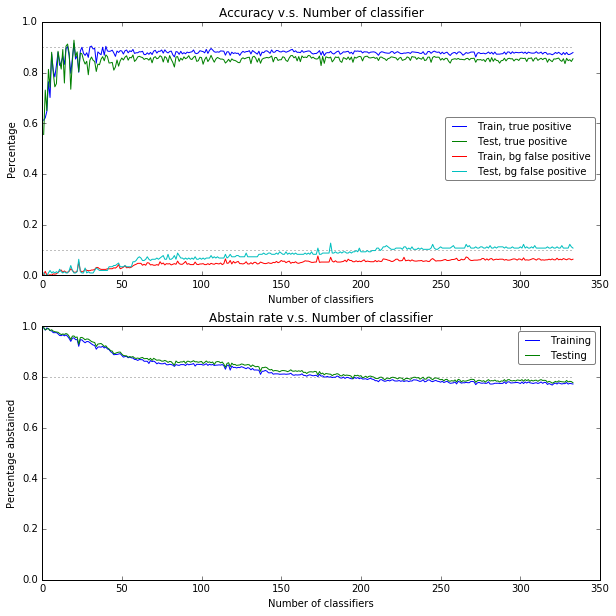

In [15]:
n_clf = len(bst.clfs);
plt.figure(figsize=(10,10));
plt.subplot(211);
plt.title("Accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_staged_tp, label='Train, true positive');
plt.plot(range(1, n_clf + 1), test_staged_tp, label='Test, true positive');
plt.plot(range(1, n_clf + 1), train_staged_fp, label='Train, bg false positive');
plt.plot(range(1, n_clf + 1), test_staged_fp, label='Test, bg false positive');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
plt.hlines(0.9, 0, n_clf, linestyles=':', color='grey');
plt.hlines(0.1, 0, n_clf, linestyles=':', color='grey');

plt.subplot(212);
plt.title("Abstain rate v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage abstained");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_abstain_rate, label='Training');
plt.plot(range(1, n_clf + 1), test_abstain_rate, label='Testing');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
plt.hlines(0.8, 0, n_clf, linestyles=':', color='grey');

In [16]:
clf_radius = [(1 - clf.t) for clf in bst.clfs];
clf_acc = [clf.acc for clf in bst.clfs];
clf_alpha = [clf.alpha for clf in bst.clfs];
clf_index = [clf.index for clf in bst.clfs];
clf_unweighted_acc = [clf.unweighted_acc for clf in bst.clfs];
clf_label = [clf.l for clf in bst.clfs];
clf_size = [clf.size for clf in bst.clfs];
clf_label_distribution = [clf.label_distribution for clf in bst.clfs];

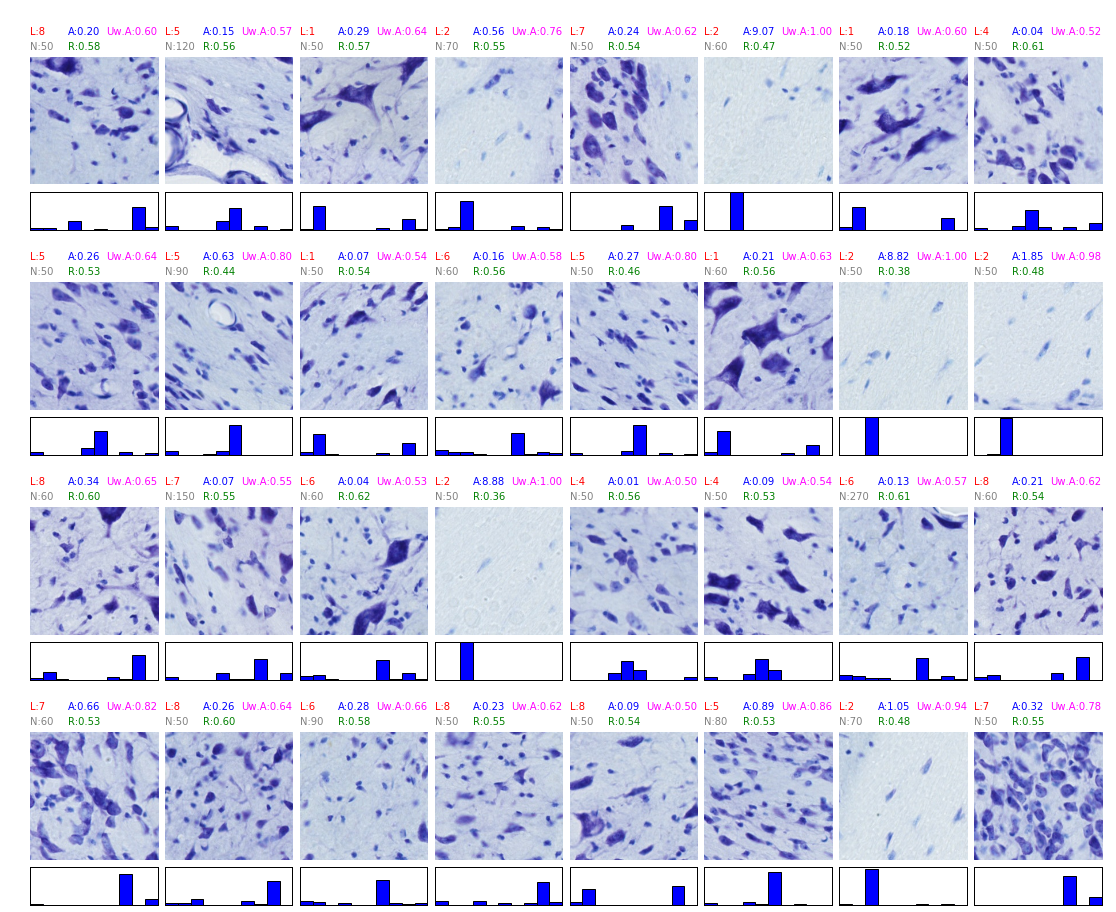

In [21]:
subplot_width = 2.4;
subplot_height = 4;
fig_row = 4;
fig_col = 8;
plt.figure(figsize=(subplot_width * fig_col, subplot_height * fig_row));
plt.title('Information of hypersphere: (label, alpha, radius, number of examples)');
for row in range(0, fig_row):
    for col in range(0, fig_col):
        i = row * fig_col + col;
        ax0 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row, 3 * col), colspan=3);
        ax0.text(0.0, 0.4, 'L:{}'.format(clf_label[i]), fontsize=10, color='red');
        ax0.text(0.0, 0.0, 'N:{}'.format(clf_size[i]), fontsize=10, color='grey');
        ax0.text(0.3, 0.4, 'A:{:.2f}'.format(clf_alpha[i]), fontsize=10, color='blue');
        ax0.text(0.6, 0.4, 'Uw.A:{:.2f}'.format(clf_label_distribution[i][clf_label[i]]), fontsize=10, color='magenta');
        ax0.text(0.3, 0.0, 'R:{:.2f}'.format(clf_radius[i]), fontsize=10, color='green');
        ax0.axison=False;
        img=imread(training_f[clf_index[i]]);
        ax1 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 1, 3 * col), rowspan=3, colspan=3);
        ax1.imshow(img, cmap=plt.cm.gray);
        ax1.axis('off');
        ax2 = plt.subplot2grid((5 * fig_row, 3 * fig_col), (5 * row + 4, 3 * col), colspan=3);
        ax2.bar(np.arange(0, 10), clf_label_distribution[i], width=1);
        ax2.axes.get_yaxis().set_visible(False);
        ax2.axes.get_xaxis().set_visible(False);
        ax2.axes.set_ylim([0.0, 1.0]);

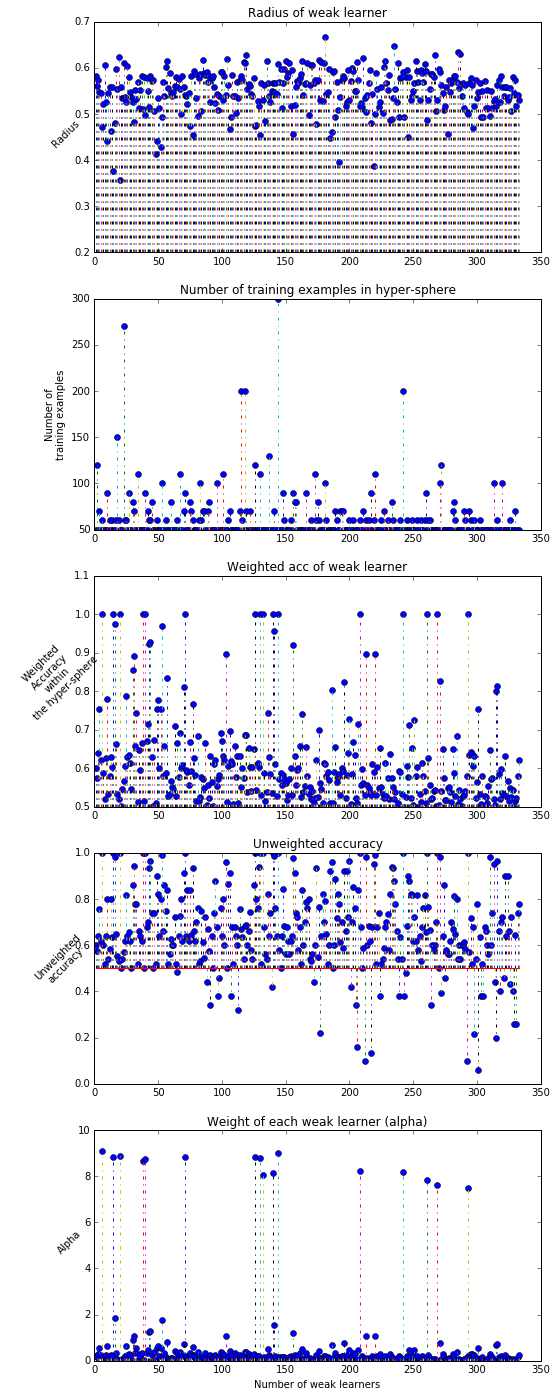

In [17]:
plt.figure(figsize=(8, 24));
plt.subplot(511);
plt.title("Radius of weak learner");
plt.ylabel("Radius", rotation=45);
plt.stem(range(1, n_clf + 1), clf_radius, '-.', bottom=0.2);

plt.subplot(512);
plt.title("Number of training examples in hyper-sphere");
plt.ylabel("Number of\ntraining examples");
plt.stem(range(1, n_clf + 1), clf_size, '-.', bottom=50);

plt.subplot(513);
plt.title("Weighted acc of weak learner");
plt.ylabel("Weighted\nAccuracy\nwithin\nthe hyper-sphere", rotation=45);
plt.stem(range(1, n_clf + 1), clf_acc, '-.', bottom=0.5);

plt.subplot(514);
plt.title("Unweighted accuracy");
plt.ylabel("Unweighted\naccuracy", rotation=45);
plt.stem(range(1, n_clf + 1), clf_unweighted_acc, '-.', bottom=0.5);

plt.subplot(515);
plt.title("Weight of each weak learner (alpha)");
plt.xlabel('Number of weak learners');
plt.ylabel("Alpha", rotation=45);
plt.stem(range(1, n_clf + 1), clf_alpha, '-.', bottom=0);

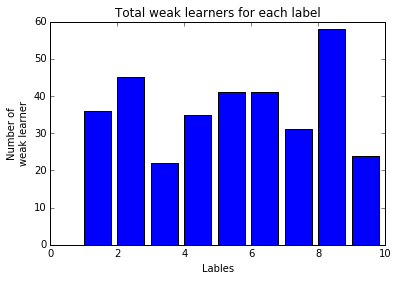

In [18]:
plt.subplot(111);
plt.title("Total weak learners for each label");
plt.xlabel("Lables");
plt.ylabel("Number of\nweak learner");
count = np.bincount(clf_label, minlength=10);
plt.bar(np.arange(0, 10), count);

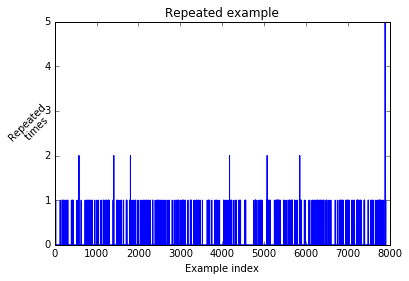

In [19]:
unique_example = np.bincount(np.array(clf_index));
plt.subplot(111);
plt.title("Repeated example");
plt.xlabel("Example index");
plt.ylabel("Repeated\n times", rotation=45);
plt.plot(unique_example);

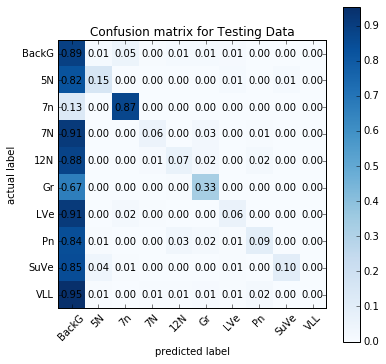

In [20]:
test_final_predict = test_staged_result[-1];

cm_test = confusion_matrix(testing_y, test_final_predict);
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(6, 6));
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Testing Data');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45);
plt.yticks(tick_marks, labels);

ax = fig.add_subplot(111);
for x in xrange(len(labels)):
    for y in xrange(len(labels)):
        ax.annotate(
            "%.2f" % cm_test[x][y], 
            xy=(y, x), 
            horizontalalignment='center',
            verticalalignment='center');

In [ ]:
for i in range(0, len(bst.clfs)):
    neighbor_indices = bst.clfs[i].neighbor_indices;
    neighbor_labels = training_y[neighbor_indices];
    neighbor_f = [training_f[neighbor] for neighbor in neighbor_indices];
    count = np.bincount(neighbor_labels, minlength=10);
    count[bst.clfs[i].l] += 1; # Add exemplar itself
    fig_col = 21;
    n_label_rows = count / fig_col + 1;
    fig_row = np.sum(n_label_rows) + 1;
    patch_size = 1.0;
    plt.figure(figsize=(patch_size*fig_col, patch_size*fig_row));
    # Plot weak learner basic infomation
    ax = plt.subplot2grid((fig_row, fig_col), (0,  0), colspan=8);
    ax.text(0.0, 0.5, 'Label:  {}'.format(labels[clf_label[i]]), fontsize=15, color='red');
    ax.text(0.0, 0.0, 'N_smpl: {}'.format(clf_size[i]), fontsize=15, color='grey');
    ax.text(0.3, 0.5, 'Alpha:  {:.2f}'.format(clf_alpha[i]), fontsize=15, color='blue');
    ax.text(0.3, 0.0, 'Radius: {:.2f}'.format(clf_radius[i]), fontsize=15, color='green');
    ax.text(0.6, 0.5, 'Unweighted acc: {:.2f}'.format(clf_label_distribution[i][bst.clfs[i].l]), fontsize=15, color='magenta');
    ax.axison=False;
    # Plot the accuracy vs. radius
    exemplar_index = bst.clfs[i].index;
    label_of_interest = bst.clfs[i].l;
    neighbor_scores = myKernel[exemplar_index];
    score_label = sorted(zip(neighbor_scores, training_y),
                         key=lambda x: x[0], reverse=True);
    radius_list = [];
    acc_list = [];
    n_correct = 1;
    n_total = 1;
    for j in range(1, n_training):
        n_total += 1;
        if score_label[j][1] == label_of_interest:
            n_correct += 1;
        radius_list.append(1 - score_label[j][0]);
        acc_list.append(1.0*n_correct / n_total);
    ax = plt.subplot2grid((fig_row, fig_col), (0,  9), colspan=4);
    ax.plot(radius_list, acc_list);
    ax.set_xlabel('Radius (1.0 - score)');
    ax.set_ylabel('Unw. Acc');
    ax.xaxis.set_ticks_position('bottom');
    ax.yaxis.set_ticks_position('left');
    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    ax.axes.set_ylim([0.0, 1.0]);
    ax.vlines(clf_radius[i], 0, 1.0, linestyles=':', color='r');
    # Plot label number
    next_row = 1;
    for j in range(0, 10):
        ax = plt.subplot2grid((fig_row, fig_col), (next_row,  0));
        ax.text(0.0, 0.4, '{}'.format(labels[j]), fontsize=15, color='blue');
        ax.axison=False
        next_row += 1;
        for index in range(1, n_label_rows[j]):
            next_row += 1;

    next_col = np.zeros(10, dtype=int);
    next_col.fill(1);
    # Plot exemplar
    ax = plt.subplot2grid((fig_row, fig_col), (np.sum(n_label_rows[:bst.clfs[i].l]) + 1, 1));
    img=imread(training_f[bst.clfs[i].index]);
    ax.imshow(img, cmap=plt.cm.gray);
    ax.axes.get_yaxis().set_visible(False);
    ax.axes.get_xaxis().set_visible(False);
    for spine in ax.spines.values():
        spine.set_edgecolor('red');
        spine.set_linewidth(4);

    next_col[bst.clfs[i].l] += 1;
    # Plot others
    for j in range(len(neighbor_indices)):
        label = neighbor_labels[j];
        f = neighbor_f[j];
        if next_col[label] % fig_col == 0:
            next_col[label] += 1;
        ax = plt.subplot2grid((fig_row, fig_col), (np.sum(n_label_rows[:label]) + next_col[label] / fig_col + 1,
                                                   next_col[label] % fig_col));
        next_col[label] += 1;
        img=imread(f);
        ax.imshow(img, cmap=plt.cm.gray);
        ax.text(0, 200, str(j), fontsize=15, color='yellow');
        ax.axison=False;
#     plt.savefig(figsaveDir + 'neighbor_' + str(i).zfill(3) + '.png');